<a href="https://colab.research.google.com/github/Clearbloo/Feynman_GNN/blob/main/dataset_builder_v3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
## Standard libraries
import os
import os.path as osp
import numpy as np 
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

C:\Users\loren\AppData\Local\Temp\ipykernel_13320\2481754896.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


# **Plan**


---


# Nodes:
Node list.

* 1 - Internal node
* 2 - Initial state nodes
* 3 - Final state nodes

The intention is to add information about the time direction. Could investigate the effect of including this.

e.g. 

```
node_features = [2, 2, 1, 1, 3, 3]
```



---


# Edge features/attributes:
Each edge comes with a list of features.

\begin{equation}
l = \begin{bmatrix}
m, & S, &LI^{W}_3, & LY, &RI^W_3, &RY,  &\text{red}, &\text{blue}, &\text{green},&\text{anti-red},&\text{anti-blue},&\text{anti-green}, &h, & \mathbf{p}
\end{bmatrix}
\end{equation}

Where $m$ is the on-shell mass. Examples of particles.

NEED TO CORRECT MY COLOUR EXAMPLES
Lepton:

\begin{align}
  e^-_\uparrow &= \begin{bmatrix}
   m_e, & \frac{1}{2}, & -\frac{1}{2}, & -1,& 0,& -2, & 0, & +1, & \mathbf{p}
  \end{bmatrix} \\[1em]
  e^-_\downarrow &= \begin{bmatrix}
   m_e, & \frac{1}{2}, & -\frac{1}{2}, & -1,& 0,& -2, & 0, & -1, & \mathbf{p}
  \end{bmatrix}\\[1em]
  e^+_\uparrow &= \begin{bmatrix}
    m_e, & \frac{1}{2}, & 0, &+2, &+\frac{1}{2}, &+1, & 0, & +1, & \mathbf{p}
  \end{bmatrix} \\[1em]
  e^+_\downarrow &= \begin{bmatrix}
    m_e, & \frac{1}{2}, & 0, &+2, &+\frac{1}{2}, &+1, & 0, & -1, & \mathbf{p}
  \end{bmatrix}
\end{align}

Photon:

\begin{align}
  \gamma = \begin{bmatrix}
    0, &1, &0, &0, &0, &0, &0, &h, &\mathbf{p}
  \end{bmatrix}
\end{align}

Colour is the number of colour charges the particle has, e.g. quarks have 1 and gluons have 2
---



# Edge Index (adjacency list):
A list of doublets that describe which edges connect to which.

e.g.
```
edge_index = [[1,2],[2,1],[1,3],[3,1]]
```




---

#**Define constants**

Always using natural units in MeV

In [75]:
#lepton masses
m_e = 0.5110
m_mu = 105.6583755
m_tau = 1776

#quark masses
m_up=2.2
m_down=4.7
m_charm=1275
m_strange=95
m_top=172760
m_bottom=4180

#massive bosons
m_W = 80379
m_Z = 91187
m_H = 125100


alpha_QED = 1/137
alpha_S = 1
alpha_W = 1e-6
q_e = np.sqrt(4*np.pi*alpha_QED)
num_edge_feat = 9

---
# **Creating Graph Representation Classes**





In [76]:
def graph_combine(graph1, graph2):
  print(graph1[0])
  print(graph2[1][1])
  print(graph2[1][0])
  graph2[1][0]=[x+len(graph1[0]) for x in graph2[1][0]]
  graph2[1][1]=[x+len(graph1[0]) for x in graph2[1][1]]
  # old version, qui devono mettere -1 perchè hanno anche le feature del global node
  #graph2[1][0]=[x+len(graph1[0])-1 for x in graph2[1][0]]
  #graph2[1][1]=[x+len(graph1[0])-1 for x in graph2[1][1]]
  print(graph2[1][0])
  print(graph2[1][1])

  comb_graph = [0,0,0]
  nodes = graph1[0]+graph2[0]
  edge_index = [graph1[1][0]+graph2[1][0],graph1[1][1]+graph2[1][1]]
  edge_feat = graph1[2]+graph2[2]

  return [nodes, edge_index, edge_feat]

In [77]:
class adj_list:
    """
    Class for an directed graph. The global node is the 0th node. 
    num_nodes should include the global node
    """
    def __init__(self,num_nodes):
        self.graphsrc = []
        self.graphdest = []
        self.num_nodes = num_nodes
 
    def add_edge(self, src, dest):
        self.graphsrc += [src]
        self.graphdest += [dest]
    
    def undirected(self):
      l = self.graphsrc
      self.graphsrc = l + self.graphdest
      self.graphdest = self.graphdest + l

    def connect_global_node(self):
      for i in range(1,self.num_nodes):
        self.add_edge(i,0)

    def graph_size(self):
      """
      returns the number of edges in the graph. Doubled if self.undirected() has been called
      """
      return len(self.graphsrc)
      
    # Debug function to print the graph
    def print_list(self):
        print(self.get_list())

    def get_list(self):
      return [self.graphsrc,self.graphdest]


class Particle:
  """
  edge features vector
  l=[m,S,LIW3,LY,RIW3,RY,colour,h]
  masses in subsequent classes are given in MeV
  """
  def __init__(self, m: float, S: float, LIW: float, LY: float, RIW: float, RY:float, colour: list = [0,0,0], anti_colour: list = [0,0,0]):
    self.LIW=LIW
    self.LY=LY
    self.RIW=RIW
    self.RY=RY

    self.feat = [m, S, LIW, LY, RIW, RY, colour[0], colour[1], colour[2], anti_colour[0], anti_colour[1], anti_colour[2]]
    
  def get_feat(self):
    return self.feat
  
  def anti_particle(self):
    self.feat[2] = -self.RIW
    self.feat[3] = -self.RY
    self.feat[4] = -self.LIW
    self.feat[5] = -self.LY

  def print_feat(self):
    print(self.feat)

In [78]:
#tests
graph = adj_list(3)
graph.add_edge(1,2)
graph.add_edge(2,3)
graph.add_edge(3,1)
graph.connect_global_node()
graph.undirected()
graph = graph.print_list()

[[1, 2, 3, 1, 2, 2, 3, 1, 0, 0], [2, 3, 1, 0, 0, 1, 2, 3, 1, 2]]


#Lepton classes:
(need to include tau and all neutrinos still)

In [79]:
class E_minus(Particle):
  """
  Class to construct the edge feautres of an electron
  l=[m,S,IW3,Y,colour,h]
  """
  def __init__(self):
    """
    h = helicity 
    p = 3-momentum vector
    """
    Particle.__init__(self, m=m_e, S=0.5, LIW=-0.5, LY=-1, RIW=0, RY=-2)

class E_plus(Particle):
  """
  Class to construct the edge feautres of a positron
  """
  def __init__(self):
    """
    h = helicity 
    p = 3-momentum vector
    """
    Particle.__init__(self, m=m_e, S=0.5, LIW=0, LY=2, RIW=0.5, RY=1)

class Mu_minus(Particle):
  """
  Class to construct the edge feautres of a muon
  l=[m,S,IW3,Y,colour,h,p]
  """
  def __init__(self):
    """
    h = helicity 
    p = 3-momentum vector
    """
    Particle.__init__(self, m=m_mu, S=0.5, LIW=-0.5, LY=-1, RIW=0, RY=-2)

class Mu_plus(Particle):
  """
  Class to construct the edge feautres of an anti-muon
  """
  def __init__(self):
    """
    h = helicity 
    p = 3-momentum vector
    """
    Particle.__init__(self, m=m_mu, S=0.5, LIW=0, LY=2, RIW=0.5, RY=1)

In [80]:
test_particle = Mu_plus()
test_particle.print_feat()

[105.6583755, 0.5, 0, 2, 0.5, 1, 0, 0, 0, 0, 0, 0]


#Quark classes:

In [81]:
class Up_r(Particle):
  """
  edge features of an up quark
  """
  def __init__(self):
    Particle.__init__(self,m=m_up,S=0.5,LIW=0.5,LY=1/3,RIW=0,RY=4/3,colour=[1,0,0])

class Down_r(Particle):
  """
  edge features of a down quark
  """
  def __init__(self):
    Particle.__init__(self,m=m_down,S=0.5,LIW=-0.5,LY=1/3,RIW=0,RY=-2/3,colour=[1,0,0])

class Charm_r(Particle):
  """
  edge features of a charm quark
  """
  def __init__(self):
    Particle.__init__(self,m=m_charm,S=0.5,LIW=0.5,LY=1/3,RIW=0,RY=4/3,colour=[1,0,0])

class Strange_r(Particle):
  """
  edge features of a strange quark
  """
  def __init__(self):
    Particle.__init__(self,m=m_strange,S=0.5,LIW=-0.5,LY=1/3,RIW=0,RY=-2/3,colour=[1,0,0])

class Top_r(Particle):
  """
  edge features of a top quark
  """
  def __init__(self):
    Particle.__init__(self,m=m_top,S=0.5,LIW=0.5,LY=1/3,RIW=0,RY=4/3,colour=[1,0,0])
    
class Bottom_r(Particle):
  """
  edge features of a bottom quark
  """
  def __init__(self):
    Particle.__init__(self,m=m_bottom,S=0.5,LIW=-0.5,LY=1/3,RIW=0,RY=-2/3,colour=[1,0,0])

#Boson classes:

In [82]:
class Photon(Particle):
  """
  edge features of a photon
  """
  def __init__(self):
    Particle.__init__(self, m=0, S=1, LIW=0, LY=0, RIW=0, RY=0)

class Gluon_rbbar(Particle):
  """
  edge features of a gluon
  """
  def __init__(self):
    Particle.__init__(self,m=0,S=1,LIW=0,LY=0,RIW=0,RY=0,colour=[1,0,0],anti_colour=[0,1,0])

class W_plus(Particle):
  """
  edge features of W plus boson
  """
  def __init__(self):
    Particle.__init__(self,m=m_W,S=1,LIW=1,LY=0,RIW=0,RY=0)

class W_minus(Particle):
  """
  edge features of W minus boson
  """
  def __init__(self):
    Particle.__init__(self,m=m_W,S=1,LIW=-1,LY=0,RIW=0,RY=0)

class Z_0(Particle):
  """
  edge features of Z boson
  """
  def __init__(self):
    Particle.__init__(self,m=m_Z,S=1,LIW=0,LY=0,RIW=0,RY=0)
    
class Higgs(Particle):
  """
  edge features of W plus boson
  """
  def __init__(self):
    Particle.__init__(self,m=m_H,S=0,LIW=-0.5,LY=1,RIW=0,RY=0)

#**Diagram structures**

#s-channel

In [83]:
def s_channel():
  initial = [1,0,0]
  virtual = [0,1,0]
  final = [0,0,1]

  # NEL CASO RIAGGIUNGERE IL GLOBAL NODE!!!
  #Global node (I happen to be lucky in that these are the same size, 3)
  global_node = [alpha_QED,alpha_W,alpha_S]

  #Node features
  #node_features = [initial, initial, virtual, virtual, final, final]
  node_features = [global_node, initial, initial, virtual, virtual, final, final]
  num_nodes=len(node_features)

  #Adjacency lists. The order in which the first and last two nodes are added IS IMPORTANT. initial_1 = node 1. final_5=node 5 etc
  s_chan = adj_list(num_nodes)
  s_chan.add_edge(1,3) #must connect to first initial state
  s_chan.add_edge(2,3) #must connect to second initial state
  s_chan.add_edge(3,4)
  s_chan.add_edge(4,5) #must connect to first final state
  s_chan.add_edge(4,6) #must connect to second final state

  edge_index = s_chan

  return node_features, edge_index

#t-channel

In [84]:
def t_channel():
  initial = [1,0,0]
  virtual = [0,1,0]
  final = [0,0,1]

  #NEL CASO RIAGGIUNGERE IL GLOBAL NODE!!!
  #Global node
  global_node = [alpha_QED,alpha_W,alpha_S]

  #Node features
  #node_features = [initial, initial, virtual, virtual, final, final]
  node_features = [global_node, initial, initial, virtual, virtual, final, final]
  num_nodes= len(node_features)

  #Adjacency lists
  t_chan = adj_list(num_nodes)
  t_chan.add_edge(1,3)
  t_chan.add_edge(2,4)
  t_chan.add_edge(3,4)
  t_chan.add_edge(3,5)
  t_chan.add_edge(4,6)

  edge_index = t_chan

  return node_features, edge_index

#u-channel

In [85]:
def u_channel():
  initial = [1,0,0]
  virtual = [0,1,0]
  final = [0,0,1]

  # NEL CASO RIAGGIUNGERE IL GLOBAL NODE!!!
  #Global node
  global_node = [alpha_QED,alpha_W,alpha_S]

  #Node features
  #node_features = [initial, initial, virtual, virtual, final, final]
  node_features = [global_node, initial, initial, virtual, virtual, final, final]
  num_nodes = len(node_features)
  
  #Adjacency lists
  u_chan = adj_list(num_nodes)
  u_chan.add_edge(1,3)
  u_chan.add_edge(2,4)
  u_chan.add_edge(3,4)
  u_chan.add_edge(3,6)
  u_chan.add_edge(4,5)#in the u-channel, the first initial state connects to the first final state

  edge_index = u_chan

  return node_features, edge_index

#**Feynman Diagram builder**

A function to create a list of all possible diagrams

1.   Takes in initial and final particle states
2.   Iterates over diagram structures (s,t,u for tree level)
3.   Iterates over vertices
4.   Removes diagrams that don't follow conservation rules





# **Create Tree-level QED Dataset**

We start with simple electron positron to muon antimuon QED tree level scattering. This removes the need for the t-channel diagram. And we only need to consider the s-channel diagram.

The structure is to create a list for each of the features.

Then create a list of lists to represent the data for a singular graph

Then create a stacked list of lists of lists to represent the full dataset which then gets passed to pandas.dataframe

As a numpy array, this will be a 2D array (num_graphs, num_feature_type) with the objects as lists.

I first give the 4 non-zero matrix elements and then include two that are zero.

In [86]:
def vertex_check(vertex, edge_feat, edge_index):
  """
  Function that returns a true or false based on whether quantities are conserved at the specified vertex
  """
  #incoming indices since edge_index[1] are the destinations
  inc_indices = [k for k,x in enumerate(edge_index[1]) if x==vertex]
  inc_edges=[0]*len(edge_feat[0])
  for n in inc_indices:
    inc_edges = [sum(value) for value in zip(edge_feat[n], inc_edges)]

  #outgoing indices since edge_index[0] are the sources
  out_indices = [k for k,x in enumerate(edge_index[0]) if x==vertex]
  out_edges=[0]*len(edge_feat[0])
  for n in out_indices:
    out_edges = [sum(value) for value in zip(edge_feat[n], out_edges)]
  
  current = [sum(value) for value in zip(inc_edges, [-x for x in out_edges])]
  conservation=[current[2]+0.5*current[3], #Left charge, weak isospin - 1/2 left hypercharge
                current[4]+0.5*current[5], #"" for the right chiral
                current[6]-current[9], # red colour charge conservation (red - anti-red)
                current[7]-current[10], #blue colour charge conservation (blue - anti-blue)
                current[8]-current[11], #green ""
  ]
  return all(float(charge)==0.0 for charge in conservation)

In [87]:
def diagram_builder(initial_0, initial_1, final_4, final_5,channel,global_connect: bool):
  """
  Function to make return all possbile diagrams with initial and final states given
  Returns a list allowed graphs, which consist of Feyn_vertex, edge_index and edge_feat
  Changes: should allow feynman diagrams with False to be returned but force them to have matrix element 0; exclude certain vertices e.g. connecting electron to muon
  """
  Feyn_vertex, adj_class = channel
  num_edges = adj_class.graph_size()
  edge_index = adj_class.get_list()
  #check to see if process is kinematically allowed by conserving energy, helicity and momentum (need to add)

  #Given edge features
  incoming_0 = initial_0.get_feat()
  incoming_1 = initial_1.get_feat()
  outgoing_4 = final_4.get_feat()
  outgoing_5 = final_5.get_feat()

  #make empty edge feature list for directed graph
  edge_feat = [0]*num_edges

  #assign initial and final edge feats. NEED TO CHANGE THIS TO SEARCH FOR INIT AND FINAL NODES AS THE INDICES
  edge_feat[0] = incoming_0
  edge_feat[1] = incoming_1
  edge_feat[-2] = outgoing_4
  edge_feat[-1] = outgoing_5

  #create a list of allowed edges to insert between virtual nodes
  graphs = []
  propagators = []
  edge_position = []
  for i in range(len(edge_index[0])): #len(edge_index[0] is the number of edges)
    #look for virtual nodes connected to virtual nodes
    if Feyn_vertex[edge_index[0][i]] == [0,1,0] and Feyn_vertex[edge_index[1][i]] == [0,1,0]: #1-hot encoding for virtual nodes 
      #cycle through list of bosons (just photons for now)
      edge_feat[i]=Photon().get_feat()
      if vertex_check(edge_index[0][i],edge_feat,edge_index):
        propagators.append(edge_feat[i])
        edge_position.append(i)
      if not propagators: #checks to see if the list is empty
        return []
  
  for i in range(len(edge_feat)):
     edge_feat[i] = edge_feat[i][0:6]

  #cycle through edge_position
  """
  look at edge positions, take all the indices in edge positions
  make lists for each 
  """

  #Connect the global node and make the graph undirected
  if global_connect == True:
    adj_class.connect_global_node()

    #add global node edge features
    num_nodes = len(Feyn_vertex) #including super node
    for i in range(1,num_nodes):
      global_edge_features=[0]*len(edge_feat[0])
      edge_feat.append(global_edge_features)

  #HO TOLTO QUESTA PARTE!!
  #adj_class.undirected()
  edge_index = adj_class.get_list()

  #make the features undirected, L'HO TOLTA!!
  #edge_feat += edge_feat
  graphs.append([Feyn_vertex,edge_index,edge_feat])
  graphs[0][0] = graphs[0][0][1:7] # ho aggiunto questa parte per tagliare il nodo globale
    
  return graphs[0]

In [165]:
def dataframe_builder(theta_min,ang_res,p_res,p_min,p_max,Mfi_squared,graph, scatt_index, theta_max=np.pi):
  #Setup: First make the dataframe a long list of arrays. 20,000 data points
  momenta_range=np.linspace(p_min, p_max, p_res) 
  dataframe = np.empty(shape=(ang_res*p_res,7),dtype=object)

  #Index to count the graph number
  graph_count=0

  for p in momenta_range:
    for theta in np.linspace(theta_min,theta_max,ang_res):
        
      #Graph-level target
      target = Mfi_squared(p,theta)

      #Create the dataframe as an numpy array first. Need to add a way to handle empty graphs
      dataframe[graph_count,0]=graph[0]
      dataframe[graph_count,1]=graph[1]
      dataframe[graph_count,2]=graph[2]
      dataframe[graph_count,3]=target
      dataframe[graph_count,4]=p
      dataframe[graph_count,5]=theta
      dataframe[graph_count,6]=scatt_index
    

      #increment the index
      graph_count += 1

  dataframe = pd.DataFrame(dataframe, columns=['x','edge_index','edge_attr','y','p','theta', 'graph_index'], index=np.arange(0,dataframe.shape[0],1))
  #dataframe['y_scaler'] = dataframe['y'].max()
  #dataframe['p_scaler'] = dataframe['p'].max()
  #dataframe['y_norm'] = dataframe['y']/dataframe['y'].max()
  #dataframe['p_norm'] = dataframe['p']/dataframe['p'].max()
  return dataframe

In [162]:
def dataframe_builder(theta_min,ang_res,p_res,p_min,p_max,Mfi_squared,graph, scatt_index, theta_max=np.pi):
  #Setup: First make the dataframe a long list of arrays. 20,000 data points
  momenta_range=np.linspace(p_min, p_max, p_res) 
  dataframe = np.empty(shape=(ang_res,7),dtype=object)

  #Index to count the graph number
  graph_count=0

  p = 0.1
    
  for theta in np.linspace(theta_min,theta_max,ang_res):
        
    #Graph-level target
    target = Mfi_squared(p,theta)

    #Create the dataframe as an numpy array first. Need to add a way to handle empty graphs
    dataframe[graph_count,0]=graph[0]
    dataframe[graph_count,1]=graph[1]
    dataframe[graph_count,2]=graph[2]
    dataframe[graph_count,3]=target
    dataframe[graph_count,4]=p
    dataframe[graph_count,5]=theta
    dataframe[graph_count,6]=scatt_index
    

    #increment the index
    graph_count += 1

  dataframe = pd.DataFrame(dataframe, columns=['x','edge_index','edge_attr','y','p','theta', 'graph_index'], index=np.arange(0,dataframe.shape[0],1))
  #dataframe['y_scaler'] = dataframe['y'].max()
  #dataframe['p_scaler'] = dataframe['p'].max()
  #dataframe['y_norm'] = dataframe['y']/dataframe['y'].max()
  #dataframe['p_norm'] = dataframe['p']/dataframe['p'].max()
  return dataframe

### Create a dataset for the scattering: 
$$e^+ e^- \to \mu^+ \mu^-$$
(only 1 Feynman Diagram, s-channel)

In [163]:
#write the matrix element as a function
def Mfi_squared(p, theta):
  return ((q_e**2*(1+np.cos(theta)))**2+(q_e**2*(1-np.cos(theta)))**2)/2

graph = diagram_builder(E_minus(),E_plus(),Mu_minus(),Mu_plus(),s_channel(),False)
print(graph)
df_e_annih_mu = dataframe_builder(0,ang_res=100,p_res=100,p_min=10**3,p_max=10**5,Mfi_squared=Mfi_squared, graph=graph, scatt_index='e_mu_s', theta_max=np.pi)

[[[1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 0, 1], [0, 0, 1]], [[1, 2, 3, 4, 4], [3, 3, 4, 5, 6]], [[0.511, 0.5, -0.5, -1, 0, -2], [0.511, 0.5, 0, 2, 0.5, 1], [0, 1, 0, 0, 0, 0], [105.6583755, 0.5, -0.5, -1, 0, -2], [105.6583755, 0.5, 0, 2, 0.5, 1]]]


In [164]:
#save the file
filepath = '/Users/loren/PycharmProjects/FDQLearn/data/dataset'
os.makedirs(filepath, exist_ok=True)  
df_e_annih_mu.to_csv(path_or_buf="/Users/loren/PycharmProjects/FDQLearn/data/dataset/QED_data_e_annih_mu.csv")

### Creating the dataset for Bhabha scattering: 
$$e^-e^+\to e^-e^+$$
(2 Feynman Diagrams, both s-channel and t-channel)

#### CSV for only Bhabha scattering, s-channel

In [69]:
def Mfi_squared(p, theta):
  return ((q_e**2*(1+np.cos(theta)))**2+(q_e**2*(1-np.cos(theta)))**2)/2

graph = diagram_builder(E_minus(),E_plus(),E_minus(),E_plus(),s_channel(),False)

df_e_annih_e_s = dataframe_builder(0.5,ang_res=1000,p_res=100,p_min=10**3,p_max=10**5,Mfi_squared=Mfi_squared,graph=graph, scatt_index='e_e_s')

Saving the CSV for the s-channel

In [70]:
#save the file
filepath = '/Users/loren/PycharmProjects/FDQLearn/data/dataset'
os.makedirs(filepath, exist_ok=True)  
df_e_annih_e_s.to_csv(path_or_buf="/Users/loren/PycharmProjects/FDQLearn/data/dataset/QED_data_e_annih_e_s.csv")

#### CSV for only Bhabha scattering, t-channel

In [71]:
def Mfi_squared(p, theta):
  return 2*q_e**4*(4+(1+np.cos(theta))**2)/(1-np.cos(theta))**2

graph = diagram_builder(E_minus(),E_plus(),E_minus(),E_plus(),t_channel(),False)

df_e_annih_e_t = dataframe_builder(0.5,ang_res=1000,p_res=100,p_min=10**3,p_max=10**5,Mfi_squared=Mfi_squared,graph=graph, scatt_index='e_e_t')

Saving the CSV for the t-channel of Bhabha scattering

In [72]:
#save the file
filepath = '/Users/loren/PycharmProjects/FDQLearn/data/dataset'
os.makedirs(filepath, exist_ok=True)  
df_e_annih_e_t.to_csv(path_or_buf="/Users/loren/PycharmProjects/FDQLearn/data/dataset/QED_data_e_annih_e_t.csv")

## Concatenating the three different Feynman Diagrams


In [73]:
df_qed = pd.concat([df_e_annih_e_s, df_e_annih_e_t],ignore_index=True)
df_qed.to_csv(path_or_buf="/Users/loren/PycharmProjects/FDQLearn/data/dataset/QED_data_qed.csv")

### Massive Scattering for:
$$e^+ e^- \to \mu^+ \mu^-$$

In [172]:
#write the matrix element as a function
def Mfi_squared(p, theta):
  return q_e**4*(1+(p*np.cos(theta))**2*(1/(p**2 + m_e**2) - (m_mu/(p**2+m_e**2))**2)+
                    (m_e**2 + m_mu**2)/(4*(p**2 + m_e**2)))

graph = diagram_builder(E_minus(),E_plus(),Mu_minus(),Mu_plus(),s_channel(),False)
print(graph)
df_e_annih_mu_massive = dataframe_builder(0,ang_res=100,p_res=100,p_min=120,p_max=250,Mfi_squared=Mfi_squared, graph=graph, scatt_index='e_mu_s', theta_max=np.pi)

[[[1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 0, 1], [0, 0, 1]], [[1, 2, 3, 4, 4], [3, 3, 4, 5, 6]], [[0.511, 0.5, -0.5, -1, 0, -2], [0.511, 0.5, 0, 2, 0.5, 1], [0, 1, 0, 0, 0, 0], [105.6583755, 0.5, -0.5, -1, 0, -2], [105.6583755, 0.5, 0, 2, 0.5, 1]]]


In [173]:
#save the file
filepath = '/Users/loren/PycharmProjects/FDQLearn/data/dataset'
os.makedirs(filepath, exist_ok=True)  
df_e_annih_mu_massive.to_csv(path_or_buf="/Users/loren/PycharmProjects/FDQLearn/data/dataset/QED_data_e_annih_mu_massive.csv")

<AxesSubplot:xlabel='theta', ylabel='y'>

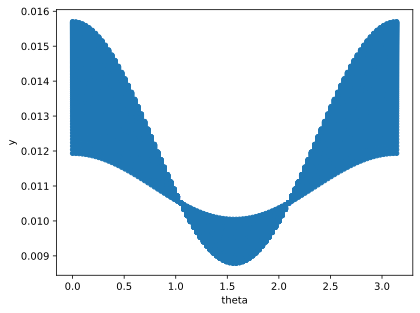

In [174]:
df_e_annih_mu_massive.plot('theta','y',kind='scatter')